In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Pulling data
drive.mount('/content/drive')
data_frame = pd.read_csv('/content/drive/My Drive/Praca_inzynierska/Data/Dane_rounded.csv', encoding='unicode_escape', sep=",")
data_frame.dtypes

Mounted at /content/drive


HourId                               int64
Month                                int64
Day                                  int64
Week day                             int64
Hour                                 int64
Dry-Bulb Temp (Â°C)                float64
Heating Load (kW)                    int64
Chiller Output (kW)                float64
Chiller Input (kW)                 float64
Total Building Electric [kW]       float64
Precool Coil Load (kW)             float64
Preheat Coil Load (kW)             float64
Terminal Cooling Coil Load (kW)    float64
Terminal Heating Coil Load (kW)    float64
Ventilation Fan (kW)               float64
Exhaust Fan (kW)                   float64
Terminal Fan (kW)                  float64
Vent. Reclaim Device (kW)          float64
Lighting (kW)                      float64
Electric Equipment (kW)            float64
dtype: object

In [ ]:
X = data_frame.drop(['HourId',
                     'Day',
                     'Chiller Output (kW)',
                     'Chiller Input (kW)',
                     'Total Building Electric [kW]',
                     'Precool Coil Load (kW)',
                     'Preheat Coil Load (kW)',
                     'Terminal Cooling Coil Load (kW)',
                     'Terminal Heating Coil Load (kW)',
                     'Ventilation Fan (kW)',
                     'Exhaust Fan (kW)',
                     'Terminal Fan (kW)',
                     'Vent. Reclaim Device (kW)',
                     'Lighting (kW)',
                     'Electric Equipment (kW)'], axis=1)
X

,Month,Week day,Hour,Dry-Bulb Temp (Â°C),Heating Load (kW)
0,1,7,0,-4.3,220
1,1,7,1,-4.1,220
2,1,7,2,-4.0,230
3,1,7,3,-3.8,230
4,1,7,4,-3.5,230
...,...,...,...,...,...
8755,12,7,19,0.2,180
8756,12,7,20,0.3,180
8757,12,7,21,0.3,180
8758,12,7,22,0.3,180


In [ ]:
X = data_frame[['Month', 'Week day', 'Hour', 'Dry-Bulb Temp (Â°C)']].values
y = data_frame['Heating Load (kW)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
import keras_tuner
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from kerastuner.tuners import RandomSearch

In [ ]:
def create_neural_network(hp):
    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='relu'))

    model.add(Dense(units= hp.Int('layer_1',
                                  min_value=16,
                                  max_value=128,
                                  step=16),
                    activation='relu'))
    model.add(Dense(units= hp.Int('layer_2',
                                  min_value=16,
                                  max_value=128,
                                  step=16),
                    activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(
                      hp.Choice('learning_rate',
                                values=[1e-2, 1e-3, 1e-4])),
                  metrics=['mae'])

    return model

In [ ]:
tuner = RandomSearch(
    create_neural_network,
    objective= 'val_mae',
    max_trials=5,
    executions_per_trial = 3,
    directory='my_dir',
    project_name='Heating_tuning_2_hidden_layers'
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
layer_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 01m 06s]
val_mae: 53.414703369140625

Best val_mae So Far: 53.414703369140625
Total elapsed time: 00h 04m 52s


In [ ]:
tuner.results_summary()

Results summary
Results in my_dir/Heating_tuning_2_hidden_layers
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 4 summary
Hyperparameters:
layer_1: 48
layer_2: 128
learning_rate: 0.01
Score: 53.414703369140625

Trial 1 summary
Hyperparameters:
layer_1: 48
layer_2: 48
learning_rate: 0.01
Score: 53.631998697916664

Trial 3 summary
Hyperparameters:
layer_1: 112
layer_2: 112
learning_rate: 0.01
Score: 53.93716049194336

Trial 0 summary
Hyperparameters:
layer_1: 112
layer_2: 64
learning_rate: 0.001
Score: 61.621910095214844

Trial 2 summary
Hyperparameters:
layer_1: 32
layer_2: 96
learning_rate: 0.0001
Score: 85.94647979736328


# **Tuning number of layers and number of neurons**

In [ ]:
def create_neural_network_2(hp):
    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='relu'))

    for i in range(hp.Int('layers', 1, 4)):
      model.add(Dense(units= hp.Int('layer_'+ str(i),
                                  min_value=16,
                                  max_value=128,
                                  step=16),
                    activation=hp.Choice('act_' + str(i), ['relu','sigmoid'])))

    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(
                      hp.Choice('learning_rate',
                                values=[1e-2, 1e-3, 1e-4])),
                  metrics=['mae'])
    return model

In [ ]:
tuner2 = RandomSearch(
    create_neural_network_2,
    objective= 'val_mae',
    max_trials=5,
    executions_per_trial = 3,
    directory='my_dir',
    project_name='Heating_tuning_final'
)

In [ ]:
tuner2.search_space_summary()

Search space summary
Default search space size: 10
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
layer_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
act_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
layer_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
act_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
layer_3 (Int)
{'default': None, 'conditions': [], 'min_value': 

In [ ]:
tuner2.search(X_train, y_train,
             epochs=20,
             validation_data=(X_test, y_test))

In [ ]:
tuner2.results_summary()

Results summary
Results in my_dir/Heating_tuning_final
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 0 summary
Hyperparameters:
layers: 2
layer_0: 96
act_0: relu
learning_rate: 0.01
layer_1: 16
act_1: relu
Score: 53.965101877848305

Trial 4 summary
Hyperparameters:
layers: 3
layer_0: 64
act_0: sigmoid
learning_rate: 0.01
layer_1: 16
act_1: sigmoid
layer_2: 64
act_2: relu
layer_3: 96
act_3: relu
Score: 57.23358027140299

Trial 1 summary
Hyperparameters:
layers: 2
layer_0: 16
act_0: relu
learning_rate: 0.01
layer_1: 80
act_1: relu
Score: 57.60533777872721

Trial 2 summary
Hyperparameters:
layers: 1
layer_0: 32
act_0: relu
learning_rate: 0.01
layer_1: 64
act_1: relu
Score: 58.90008417765299

Trial 3 summary
Hyperparameters:
layers: 4
layer_0: 112
act_0: sigmoid
learning_rate: 0.001
layer_1: 112
act_1: relu
layer_2: 16
act_2: relu
layer_3: 16
act_3: relu
Score: 59.627845764160156


Analizując powyższe wyniki, model który będzie działał najlepiej posiada dwie ukryte warstwy

*   Warstwa 1 (96 neuronów, aktywator Relu)
*   Warstwa 2 (16 neuronów, aktywator Relu)

Wynik eksperymentów osiągnął MAE na poziomie 53.97


# Tworzenie modelu

In [ ]:
def create_heating_model():
    model = Sequential()

    model.add(Dense(64, input_dim=4, activation='relu'))

    model.add(Dense(96, activation='relu'))
    model.add(Dense(16, activation='relu'))

    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    return model

In [ ]:
heating_model = create_heating_model()
history = heating_model.fit(X_train, y_train, epochs=200, batch_size=2, validation_data=(X_test, y_test))
mse, mae = heating_model.evaluate(X_test, y_test)
print(f'Mean Squared Error: {mse}, Mean Absolute Error: {mae}')

Epoch 1/200
3504/3504 [==============================] - 10s 3ms/step - loss: 18845.9941 - mae: 85.8628 - val_loss: 16772.5645 - val_mae: 80.2914
Epoch 2/200
3504/3504 [==============================] - 10s 3ms/step - loss: 14718.6299 - mae: 76.0209 - val_loss: 14587.4062 - val_mae: 74.1259
Epoch 3/200
3504/3504 [==============================] - 8s 2ms/step - loss: 12733.2178 - mae: 70.2849 - val_loss: 13401.6533 - val_mae: 69.1909
Epoch 4/200
3504/3504 [==============================] - 11s 3ms/step - loss: 11790.3057 - mae: 67.1606 - val_loss: 12861.8604 - val_mae: 70.4456
Epoch 5/200
3504/3504 [==============================] - 10s 3ms/step - loss: 11457.6689 - mae: 66.1260 - val_loss: 12498.6338 - val_mae: 68.2358
Epoch 6/200
3504/3504 [==============================] - 8s 2ms/step - loss: 11230.4111 - mae: 64.9018 - val_loss: 12482.3154 - val_mae: 66.6985
Epoch 7/200
3504/3504 [==============================] - 9s 3ms/step - loss: 10962.6357 - mae: 64.9138 - val_loss: 12591.1758 

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.legend(['Loss', 'Val_loss'], loc='upper right')
  plt.grid(True)

def plot_mae(history):
  plt.plot(history.history['mae'], label='mae')
  plt.plot(history.history['val_mae'], label='val_mae')
  #plt.xlabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['mae', 'Val_mae'], loc='upper right')
  plt.grid(True)

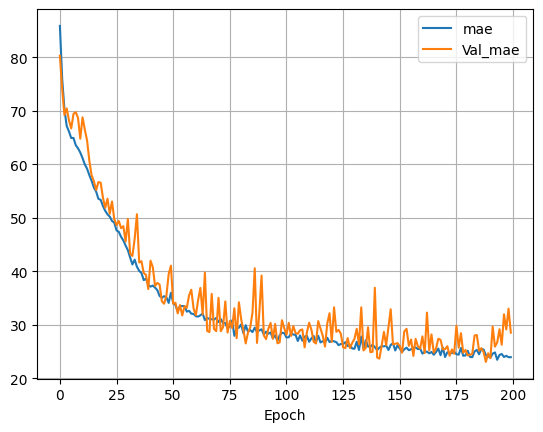

In [ ]:
plot_mae(history)

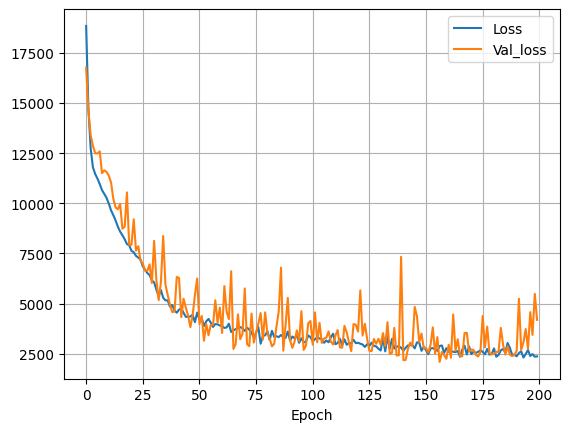

In [ ]:
plot_loss(history)

In [70]:
heating_model.save("Heating_model.keras")

# Eksperymenty

In [69]:
heating_model.save('Heating_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
from tensorflow.keras.models import load_model

loaded_model = load_model('drive/MyDrive/Praca_inzynierska/Models/Heating_model.h5')
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                320       
                                                                 
 dense_6 (Dense)             (None, 96)                6240      
                                                                 
 dense_7 (Dense)             (None, 16)                1552      
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8129 (31.75 KB)
Trainable params: 8129 (31.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [79]:
tf.saved_model.save(heating_model, 'heating_model2')

In [81]:
import pickle
model_pkl_file = "heating_model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(heating_model, file)
